# quickcat calibration 

This notebook is the quickcat calibration script.
- Its input is a redshift catalog merged with a target list and a truth table from simulations.
- Its output is a set of coefficients saved in a yaml file 
**to be copied to desisim/py/desisim/data/quickcat.yaml** . 

This notebook does sequencially :
- open the merged redshift catalog
- run quickcat on it
- for each target class
   - fit a model for redshift efficiency, and display input, quickcat, best fit model
   - fit a model for redshift uncertainty, and display input, (quickcat,) best fit model
- save the best fit parameters in a yaml file (to be copied in desisim/data/quickcat.yaml)

Please first edit first the following path:

In [1]:
# input merged catalog (from simulations for now)
simulation_catalog_filename="/home/guy/Projets/DESI/analysis/quickcat/20180926/zcatalog-redwood-target-truth.fits"
# output quickcat parameter file that this code will write
quickcat_param_filename="/home/guy/Projets/DESI/analysis/quickcat/20180926/quickcat.yaml"
# output quickcat catalog (same input target and truth)
quickcat_catalog_filename="/home/guy/Projets/DESI/analysis/quickcat/20180926/zcatalog-redwood-target-truth-quickcat.fits"

In [2]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import scipy.optimize
from pkg_resources import resource_filename
import yaml
from desisim.quickcat import eff_model,get_observed_redshifts
from desisim.simexp import reference_conditions

def efficiency(x,selection,bins=40) :
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    h1,bins=np.histogram(x[selection],bins=bins)
    ii=(h0>1)
    n=h0[ii]
    meanx=hx[ii]/n
    eff=h1[ii]/n
    err=np.zeros(eff.shape)
    eps=1e-9
    ii=(eff>eps)&(eff<(1-eps))
    err[ii]=np.sqrt(eff[ii]*(1-eff[ii]))/np.sqrt(n[ii])
    ii=(eff<=eps)
    err[ii]=1./np.sqrt(n[ii])
    err[err<0.001]=0.001
    return meanx,eff,err

def prof(x,y,bins=40) :
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    hy,bins=np.histogram(x,bins=bins,weights=y)
    hy2,bins=np.histogram(x,bins=bins,weights=y**2)
    ii=(h0>1)
    n=h0[ii]
    x=hx[ii]/n
    y=hy[ii]/n
    y2=hy2[ii]/n
    var=y2-y**2
    err=np.zeros(x.size)
    err[var>0]=np.sqrt(var[var>0])
    return x,y,err,n

def efficiency2d(x,y,selection,bins=20) :
    h0,xx,yy=np.histogram2d(x,y,bins=bins)
    h1,xx,yy=np.histogram2d(x[selection],y[selection],bins=(xx,yy))
    print(h0.shape)
    nn=(h0+(h0==0)).astype(float)
    eff=h1/nn
    err=np.zeros(eff.shape)
    eps=1e-9
    ii=(eff>eps)&(eff<(1-eps))
    tmp=eff*(1-eff)
    tmp=tmp*(tmp>0)+(tmp==0)
    err=np.sqrt(tmp)/np.sqrt(nn)
    err *= (eff<1)
    err += (err<0.01)*0.01
    err += 1000.*(nn<10)
    return xx,yy,eff,err,nn

def prof2d(x,y,z,bins=20) :
    h0,xx,yy=np.histogram2d(x,y,bins=bins)
    hz,xx,yy=np.histogram2d(x,y,bins=(xx,yy),weights=z)
    hz2,xx,yy=np.histogram2d(x,y,bins=(xx,yy),weights=z**2)
    n=(h0+(h0==0)).astype(float)
    z=hz/n
    z2=hz2/n
    var=z2-z**2
    err=np.sqrt(var*(var>0))
    x=xx[:-1]+(xx[1]-xx[0])/2.
    y=yy[:-1]+(yy[1]-yy[0])/2.
    return x,y,z,err

In [3]:
## open input file
hdulist = pyfits.open(simulation_catalog_filename)
table = hdulist["ZCATALOG"].data
print(table.dtype.names)

('TARGETID', 'CHI2', 'COEFF', 'Z', 'ZERR', 'ZWARN', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2', 'BRICKNAME', 'NUMEXP', 'NUMTILE', 'RA', 'DEC', 'MAG', 'BRICKID', 'BRICK_OBJID', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SUBPRIORITY', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'HPXPIXEL', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'VDISP', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH')


In [4]:
# quickcat parameters
quickcat_params=dict()
# quickcat output table (for display purpose only)
qtable=None

In [5]:
# run the quickcat simulation in this cell (don't necessarily have to do this to follow the rest of the notebook)

# use default parameters or the ones in the file specified above 
# (and probably obtained with a previous run of this script) if exist
input_quickcat_param_filename = None
if os.path.isfile(quickcat_param_filename) :
    input_quickcat_param_filename = quickcat_param_filename
    
# dummy tiles
targets_in_tile=dict()
targets_in_tile[0]=table["TARGETID"]

# dummy obs. conditions
tmp = reference_conditions['DARK']
tmp['TILEID']=0
obsconditions=dict()
for k in tmp :
    obsconditions[k]=np.array([tmp[k],])
    
#qtable = table.copy()
hdulist = pyfits.open(simulation_catalog_filename)
qtable = hdulist["ZCATALOG"].data

# run quickcat
# ignore_obsconditions because it only add extra noise
z, zerr, zwarn = get_observed_redshifts(qtable,qtable,targets_in_tile,obsconditions,
                                            parameter_filename=quickcat_param_filename,
                                            ignore_obscondition=True)
# replace z,zwarn and write quickcat
qtable["Z"]=z
qtable["ZWARN"]=zwarn
hdulist["ZCATALOG"].data = qtable
hdulist.writeto(quickcat_catalog_filename,overwrite=True)
print("done")


for LRG, efficiency = sigmoid with sigmoid_cutoff = 26.103947256036427 sigmoid_fudge= 0.8877446788771475
for QSO, efficiency = sigmoid with sigmoid_cutoff = 23.130609231687586 sigmoid_fudge= 0.2907391635064112
done


In [6]:
# open quickcat catalog
if qtable is None and os.path.isfile(quickcat_catalog_filename) :
    qcat_hdulist = pyfits.open(quickcat_catalog_filename)
    qtable = qcat_hdulist["ZCATALOG"].data

## ELG redshift efficiency 


We assume the ELG redshift efficiency is a function of 
 - the S/N in the emission lines, approximately proportional to OII flux.
 - the S/N in the continuum, approximately proportional to the r-band flux.
 - the redshift

We know that for a given ELG, the  S/N in the lines varies with redshift according to the flux limit defined in the FDR.
So, we will scale the OII flux with this flux limit to account for some of the redshift dependency.
We ignore the evolution of the continuum S/N with redshift for fixed r-band magnitude.


We model the efficiency with an error function,

$ Eff(SNR) = \frac{1}{2} \left( 1+Erf \left( \frac{SNR-3}{b \sqrt{2}} \right) \right) $

with 

$SNR = \sqrt{  \left(  7 \frac{OII flux}{fluxlimit} \right)^2 + \left( a \times rflux \right)^2 }$

$a$ is the continuum $SNR$ normalization, which is proportionnal to the r-band flux.

$b$ is a fudge factor. One would have $b = 1$ if $SNR$ was the variable that determines the redshift efficiency. 

However $SNR$ is only a proxy that is not 100% correlated with the efficiency, so we expect $b>1$.



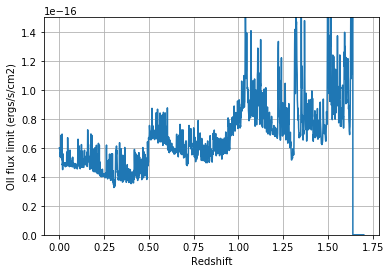

In [7]:
# OII flux limit (FDR), the has-build version should be recomputed but is probably not very different
filename = resource_filename('desisim', 'data/elg_oii_flux_threshold_fdr.txt')
fdr_z, fdr_flux_limit = np.loadtxt(filename, unpack=True)

plt.figure()
plt.plot(fdr_z, fdr_flux_limit)
plt.ylim([0,1.5e-16])
plt.xlabel("Redshift")
plt.ylabel("OII flux limit (ergs/s/cm2)")
plt.grid()

Measured ELG efficiency as a function of rmag and oii flux 

Number of ELGs=29110
(20, 20)


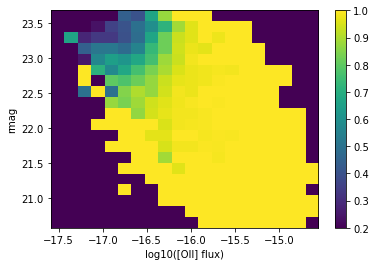

In [8]:
######################
elgs=(table["TEMPLATETYPE"]=="ELG")&(table["TRUEZ"]>0.6)&(table["TRUEZ"]<1.6)
z=table["Z"][elgs]
tz=table["TRUEZ"][elgs]
dz=z-tz
good=(table["ZWARN"][elgs]==0)
rflux=table["FLUX_R"][elgs]
print("Number of ELGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
oiiflux=table["OIIFLUX"][elgs]
oiiflux=oiiflux*(oiiflux>0)+1e-20*(oiiflux<=0)

qgood=None
if qtable is not None : #quickcat output
    qgood=(qtable["ZWARN"][elgs]==0)

######################

#good=oiiflux>8e-17 #debug to verify indexation

bins2d=20
rmag=-2.5*np.log10(rflux)+22.5
xx,yy,eff2d,err2d,nn = efficiency2d(np.log10(oiiflux),rmag,good,bins=bins2d)


plt.figure()
plt.imshow(eff2d.T,origin=0,extent=(xx[0],xx[-1],yy[0],yy[-1]),vmin=0.2,aspect="auto")
plt.xlabel("log10([OII] flux)")
plt.ylabel("rmag")
plt.colorbar()

Model

In [9]:
# model ELG efficiency vs rflux and oiiflux
oiiflux = table["OIIFLUX"][elgs]
oiiflux = oiiflux*(oiiflux>=0)+0.00001*(oiiflux<=0)
fluxlimit=np.interp(z,fdr_z,fdr_flux_limit)
fluxlimit[fluxlimit<=0]=1e-20
snr_lines=7*oiiflux/fluxlimit

def elg_efficiency_model_2d(params,log10_snr_lines,rmag) :
    p0 = params[0]
    p1 = params[1]
    p2 = params[2]
    snr_tot  = np.sqrt( (p0*10**log10_snr_lines)**2 + (p1*10**(-0.4*(rmag-22.5))) **2 )
    return 0.5*(1.+np.erf((snr_tot-3)/(np.sqrt(2.)*p2)))
        
def elg_efficiency_2d_residuals(params,log10_snr_lines,mean_rmag,eff2d,err2d) :
    
    model = elg_efficiency_model_2d(params,log10_snr_lines,mean_rmag)
    res = (eff2d-model)
    #res = (eff2d-model)/np.sqrt(err2d**2+0.5**2*(mean_rmag<22))
    res = res[err2d<2]
    #chi2 = np.sum(res**2)
    #print("params={} chi2/ndata={}/{}={}".format(params,chi2,res.size,chi2/res.size))
    return res

In [10]:
# 2d fit
#good=snr_lines>4. # debug
#good=rmag<22. # debug
xx,yy,eff2d_bis,err2d_bis,nn = efficiency2d(np.log10(snr_lines),rmag,good)
x1d = xx[:-1]+(xx[1]-xx[0])
y1d = yy[:-1]+(yy[1]-yy[0]) 
x2d=np.tile(x1d,(y1d.size,1)).T
y2d=np.tile(y1d,(x1d.size,1))

elg_efficiency_params=[1,3,2]
if 0 :
    meff2d=elg_efficiency_model_2d(elg_efficiency_params,x2d,y2d)
    i=(y2d.ravel()>22.)&(y2d.ravel()<22.4)&(err2d.ravel()<1)
    plt.plot(x2d.ravel()[i],eff2d.ravel()[i],"o")
    plt.plot(x2d.ravel()[i],meff2d.ravel()[i],"o")

(20, 20)


In [11]:
result=scipy.optimize.least_squares(elg_efficiency_2d_residuals,elg_efficiency_params,args=(x2d,y2d,eff2d_bis,err2d_bis))
elg_efficiency_params=result.x

quickcat_params["ELG"]=dict()
quickcat_params["ELG"]["EFFICIENCY"]=dict()
quickcat_params["ELG"]["EFFICIENCY"]["SNR_LINES_SCALE"]=float(elg_efficiency_params[0])
quickcat_params["ELG"]["EFFICIENCY"]["SNR_CONTINUUM_SCALE"]=float(elg_efficiency_params[1])
quickcat_params["ELG"]["EFFICIENCY"]["SIGMA_FUDGE"]=float(elg_efficiency_params[2])

print("Best fit parameters for ELG efficiency model:") 
print("SNR_lines = {:4.3f} * 7 * OIIFLUX/limit".format(elg_efficiency_params[0]))
print("SNR_cont  = {:4.3f} * R_FLUX".format(elg_efficiency_params[1]))
print("sigma fudge = {:4.3f}".format(elg_efficiency_params[2]))


Best fit parameters for ELG efficiency model:
SNR_lines = 0.577 * 7 * OIIFLUX/limit
SNR_cont  = 5.443 * R_FLUX
sigma fudge = 2.040


meff2d.shape= (20, 20)


(0.0, 1.4)

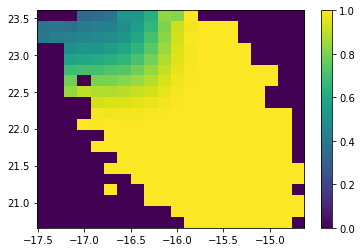

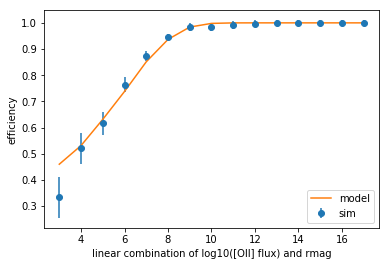

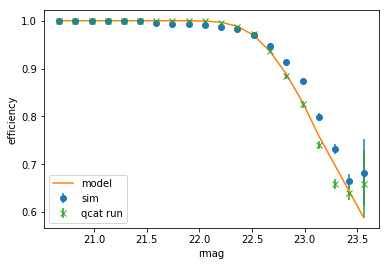

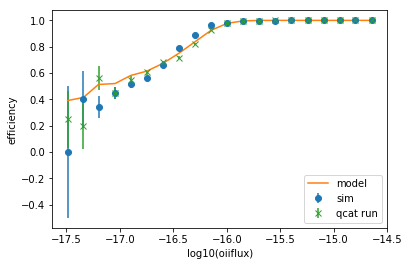

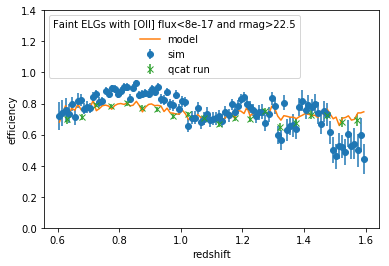

In [12]:
#params[0]=0.001 # no dependence on rmag
meff=elg_efficiency_model_2d(elg_efficiency_params,np.log10(snr_lines),rmag)
xx,yy,meff2d,merr=prof2d(np.log10(oiiflux),rmag,meff,bins=bins2d)
#plt.imshow(meff2d.T,aspect="auto")

plt.imshow(meff2d.T,origin=0,extent=(xx[0],xx[-1],yy[0],yy[-1]),aspect="auto")
plt.colorbar()


    

if 1 :
    plt.figure()
    print("meff2d.shape=",meff2d.shape)
    ii=np.arange(meff2d.shape[0])
    y1=eff2d[ii,-ii]
    e1=err2d[ii,-ii]
    y2=meff2d[ii,-ii]
    ok=(e1<1)
    plt.errorbar(ii[ok],y1[ok],e1[ok],fmt="o",label="sim")
    plt.plot(ii[ok],y2[ok],"-",label="model")
    plt.legend(loc="lower right")
    plt.xlabel("linear combination of log10([OII] flux) and rmag")
    plt.ylabel("efficiency")


plt.figure()
bins1d=20
x,eff1d,err1d   = efficiency(rmag,good,bins=bins1d)
x,meff1d,merr,nn = prof(rmag,meff,bins=bins1d)
plt.errorbar(x,eff1d,err1d,fmt="o",label="sim")
plt.plot(x,meff1d,"-",label="model")

if qgood is not None : #quickcat output
    x,eff1d,err1d   = efficiency(rmag,qgood,bins=bins1d)
    plt.errorbar(x,eff1d,err1d,fmt="x",label="qcat run")

plt.legend(loc="lower left")
plt.xlabel("rmag")
plt.ylabel("efficiency")


plt.figure()
bins1d=20
x,eff1d,err1d   = efficiency(np.log10(oiiflux),good,bins=bins1d)
x,meff1d,merr,nn = prof(np.log10(oiiflux),meff,bins=bins1d)
plt.errorbar(x,eff1d,err1d,fmt="o",label="sim")
plt.plot(x,meff1d,"-",label="model")

if qgood is not None : #quickcat output
    x,eff1d,err1d   = efficiency(np.log10(oiiflux),qgood,bins=bins1d)
    plt.errorbar(x,eff1d,err1d,fmt="x",label="qcat run")

plt.legend(loc="lower right")
plt.xlabel("log10(oiiflux)")
plt.ylabel("efficiency")


plt.figure()
fcut=8e-17
mcut=22.5
s=(oiiflux<fcut)&(rmag>mcut) # select faint ones to increase contrast in z
bins=100
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="sim")
plt.plot(x,meff1d,"-",label="model")

if qgood is not None : #quickcat output
    x,eff1d,err1d   = efficiency(tz[s],qgood[s],bins=bins1d)
    plt.errorbar(x,eff1d,err1d,fmt="x",label="qcat run")



plt.legend(loc="upper left",title="Faint ELGs with [OII] flux<{} and rmag>{}".format(fcut,mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])

## ELG redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of ELGs=29110
ELG redshift uncertainty parameters =  [6.43012258e-04 9.35233498e-01]


Text(0,0.5,'rms dz/(1+z)')

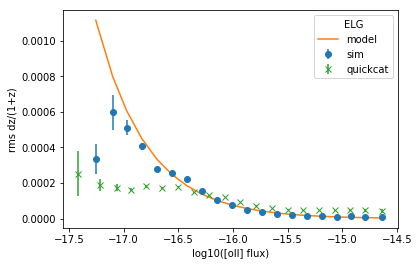

In [13]:
#ELG redshift uncertainty
######################
elgs=(table["TEMPLATETYPE"]=="ELG")&(table["TRUEZ"]>0.6)&(table["TRUEZ"]<1.6)
z=table["Z"][elgs]
dz=z-table["TRUEZ"][elgs]
good=(table["ZWARN"][elgs]==0)&(np.abs(dz/(1+z))<0.003)
rflux=table["FLUX_R"][elgs]
print("Number of ELGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
oiiflux=table["OIIFLUX"][elgs]
oiiflux=oiiflux*(oiiflux>0)+1e-20*(oiiflux<=0)
lflux=np.log10(oiiflux)

qz=None
qdz=None
if qtable is not None : # quickcat output
    qz=qtable["Z"][elgs]
    qdz=qz-qtable["TRUEZ"][elgs]
    qgood=(qtable["ZWARN"][elgs]==0)&(np.abs(qdz/(1+qz))<0.003)

######################

bins=20

binlflux,var,err,nn=prof(lflux[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(binlflux)
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

def redshift_error(params,flux) :
    return params[0]/(1e-9+flux)**params[1]

def redshift_error_residuals(params,flux,rms,rmserror) :
    model = redshift_error(params,flux)
    res = (rms-model)/np.sqrt(rmserror**2+1e-6**2)
    return res
 
#plt.plot(binlflux,rms,"o",label="meas")
plt.errorbar(binlflux,rms,rmserr,fmt="o",label="sim")
params=[0.0006,1.]
binoiiflux=np.array(10**binlflux)
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binoiiflux*1e17,rms,rmserr))
params=result.x
elg_uncertainty_params = params
print("ELG redshift uncertainty parameters = ",params)
quickcat_params["ELG"]["UNCERTAINTY"]=dict()
quickcat_params["ELG"]["UNCERTAINTY"]["SIGMA"]=float(elg_uncertainty_params[0])
quickcat_params["ELG"]["UNCERTAINTY"]["POWER_LAW_INDEX"]=float(elg_uncertainty_params[1])

m=redshift_error(params,10**binlflux*1e17)
plt.plot(binlflux,m,"-",label="model")

if qz is not None :
    qbinlflux,qvar,qerr,nn=prof(lflux[qgood],((qdz/(1+qz))**2)[qgood],bins=bins)
    qbinflux=10**(qbinlflux)
    qvar_err = np.sqrt(2/nn)*qvar
    qrms=np.sqrt(qvar)
    qrmserr=0.5*qvar_err/qrms
    plt.errorbar(qbinlflux,qrms,qrmserr,fmt="x",label="quickcat")

plt.legend(loc="upper right",title="ELG")
plt.xlabel("log10([oII] flux)")
plt.ylabel("rms dz/(1+z)")

## LRG redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$



Number of LRGs=21177
LRG redshift efficiency parameters =  [26.10394726  0.88774468]


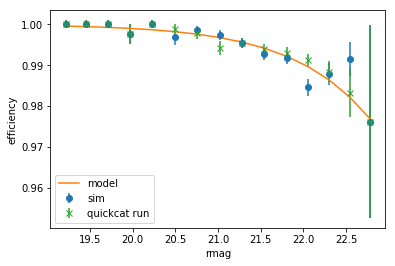

In [14]:
# simply use RFLUX for snr
######################
lrgs=(table["TEMPLATETYPE"]=="LRG")
z=table["Z"][lrgs]
tz=table["TRUEZ"][lrgs]
dz=z-tz
good=(table["ZWARN"][lrgs]==0)
rflux=table["FLUX_R"][lrgs]
print("Number of LRGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5

qgood=None
if qtable is not None : #quickcat output
    qgood=(qtable["ZWARN"][lrgs]==0)


######################

bins=15
bin_rmag,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(bin_rmag,eff,err,fmt="o",label="sim")


def sigmoid(params,x) :
    return 1/(1+np.exp((x-params[0])/params[1]))

def sigmoid_residuals(params,x,y,err) :
    m = sigmoid(params,x)
    res = (m-y)/err
    return res

lrg_efficiency_params=[26.,1.]
result=scipy.optimize.least_squares(sigmoid_residuals,lrg_efficiency_params,args=(bin_rmag,eff,err)) 
lrg_efficiency_params=result.x
plt.plot(bin_rmag,sigmoid(lrg_efficiency_params,bin_rmag),"-",label="model")

if qgood is not None:
    bin_rmag,eff,err=efficiency(rmag,qgood,bins=bins)
    plt.errorbar(bin_rmag,eff,err,fmt="x",label="quickcat run")

plt.xlabel("rmag")
plt.ylabel("efficiency")
plt.legend(loc="lower left")

print("LRG redshift efficiency parameters = ",lrg_efficiency_params)

quickcat_params["LRG"]=dict()
quickcat_params["LRG"]["EFFICIENCY"]=dict()
quickcat_params["LRG"]["EFFICIENCY"]["SIGMOID_CUTOFF"]=float(lrg_efficiency_params[0])
quickcat_params["LRG"]["EFFICIENCY"]["SIGMOID_FUDGE"]=float(lrg_efficiency_params[1])




(0.0, 1.4)

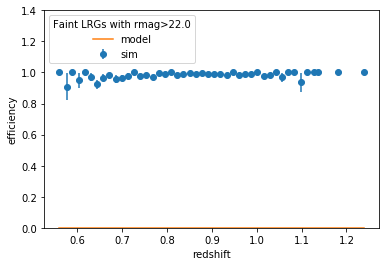

In [15]:
meff=sigmoid(params,rmag)
plt.figure()
mcut=22.
s=(rmag>mcut) # select faint ones to increase contrast in z
bins=50
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="sim")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint LRGs with rmag>{}".format(mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])

## LRG redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of LRGs=21177
LRG redshift error parameters =  [3.57946732e-04 6.02482440e-01]


Text(0,0.5,'rms dz/(1+z)')

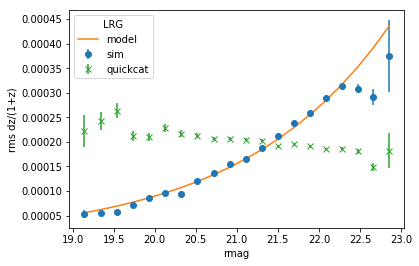

In [16]:
# LRGs redshift uncertainties

######################
lrgs=(table["TEMPLATETYPE"]=="LRG")
z=table["Z"][lrgs]
tz=table["TRUEZ"][lrgs]
dz=z-tz
good=(table["ZWARN"][lrgs]==0)&(np.abs(dz/(1+z))<0.003)
rflux=table["FLUX_R"][lrgs]
print("Number of LRGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5

qz=None
qdz=None
if qtable is not None : # quickcat output
    qz=qtable["Z"][lrgs]
    qdz=qz-qtable["TRUEZ"][lrgs]
    qgood=(qtable["ZWARN"][lrgs]==0)&(np.abs(qdz/(1+qz))<0.003)


######################

bins=20
binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

params=[1.,1.2]
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binflux,rms,rmserr))
params=result.x
print("LRG redshift error parameters = ",params)
quickcat_params["LRG"]["UNCERTAINTY"]=dict()
quickcat_params["LRG"]["UNCERTAINTY"]["SIGMA"]=float(params[0])
quickcat_params["LRG"]["UNCERTAINTY"]["POWER_LAW_INDEX"]=float(params[1])

model = redshift_error(params,binflux)

plt.errorbar(binmag,rms,rmserr,fmt="o",label="sim")
plt.plot(binmag,model,"-",label="model")


if qz is not None :
    qbinmag,qvar,qerr,nn=prof(rmag[qgood],((qdz/(1+qz))**2)[qgood],bins=bins)
    qvar_err = np.sqrt(2/nn)*qvar
    qrms=np.sqrt(qvar)
    qrmserr=0.5*qvar_err/qrms
    plt.errorbar(qbinmag,qrms,qrmserr,fmt="x",label="quickcat")




plt.legend(loc="upper left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")

## QSO tracers (z<2) redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$



Number of QSOs=10249
QSO redshift efficiency parameters =  [23.13462298  0.30059925]


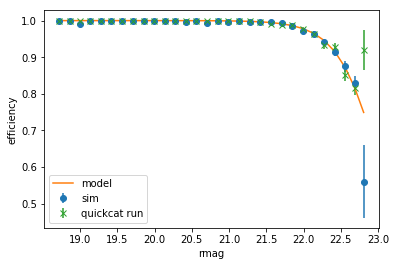

In [17]:
# simply use RFLUX for snr
######################
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["TRUEZ"]<2.)
z=table["Z"][qsos]
tz=table["TRUEZ"][qsos]
dz=z-tz
good=(table["ZWARN"][qsos]==0)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5

qgood=None
if qtable is not None : # quickcat output
    qgood=(qtable["ZWARN"][qsos]==0)


######################

bins=30
bin_rmag,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(bin_rmag,eff,err,fmt="o",label="sim")
qso_efficiency_params=[23.,0.3]
result=scipy.optimize.least_squares(sigmoid_residuals,qso_efficiency_params,args=(bin_rmag,eff,err)) 
qso_efficiency_params=result.x
plt.plot(bin_rmag,sigmoid(qso_efficiency_params,bin_rmag),"-",label="model")

if qgood is not None :
    bin_rmag,eff,err=efficiency(rmag,qgood,bins=bins)
    plt.errorbar(bin_rmag,eff,err,fmt="x",label="quickcat run")

plt.xlabel("rmag")
plt.ylabel("efficiency")
plt.legend(loc="lower left")

print("QSO redshift efficiency parameters = ",qso_efficiency_params)

quickcat_params["LOWERZ_QSO"]=dict()
quickcat_params["LOWERZ_QSO"]["EFFICIENCY"]=dict()
quickcat_params["LOWERZ_QSO"]["EFFICIENCY"]["SIGMOID_CUTOFF"]=float(qso_efficiency_params[0])
quickcat_params["LOWERZ_QSO"]["EFFICIENCY"]["SIGMOID_FUDGE"]=float(qso_efficiency_params[1])

(0.0, 1.4)

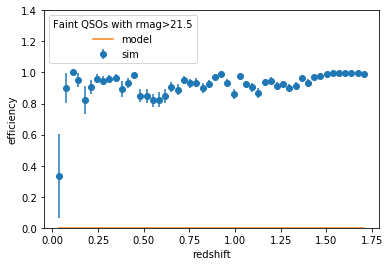

In [18]:
meff=sigmoid(params,rmag)
plt.figure()
mcut=21.5
s=(rmag>mcut) # select faint ones to increase contrast in z
bins=50
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="sim")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint QSOs with rmag>{}".format(mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])


## QSO (z<2) redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of QSOs=10249
QSO redshift error parameters =  [0.00111248 0.53624373]


Text(0,0.5,'rms dz/(1+z)')

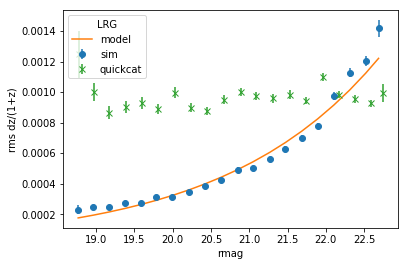

In [19]:
# QSO redshift uncertainties
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["TRUEZ"]<2.)
z=table["Z"][qsos]
dz=z-table["TRUEZ"][qsos]
good=(table["ZWARN"][qsos]==0)&(np.abs(dz/(1+z))<0.02)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5

qgood=None
qz=None
qdz=None
if qtable is not None : # quickcat output
    qz=qtable["Z"][qsos]
    qdz=qz-qtable["TRUEZ"][qsos]
    qgood=(qtable["ZWARN"][qsos]==0)&(np.abs(qdz/(1+qz))<0.02)



bins=20
binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

params=[1.,1.2]
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binflux,rms,rmserr))
params=result.x
print("QSO redshift error parameters = ",params)
quickcat_params["LOWERZ_QSO"]["UNCERTAINTY"]=dict()
quickcat_params["LOWERZ_QSO"]["UNCERTAINTY"]["SIGMA"]=float(params[0])
quickcat_params["LOWERZ_QSO"]["UNCERTAINTY"]["POWER_LAW_INDEX"]=float(params[1])

model = redshift_error(params,binflux)

plt.errorbar(binmag,rms,rmserr,fmt="o",label="sim")
plt.plot(binmag,model,"-",label="model")

if qz is not None :
    qbinmag,qvar,qerr,nn=prof(rmag[qgood],((qdz/(1+qz))**2)[qgood],bins=bins)
    qvar_err = np.sqrt(2/nn)*qvar
    qrms=np.sqrt(qvar)
    qrmserr=0.5*qvar_err/qrms
    plt.errorbar(qbinmag,qrms,qrmserr,fmt="x",label="quickcat")

plt.legend(loc="upper left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")

## Lya QSO (z>2) redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$

Number of QSOs=4287
QSO redshift efficiency parameters =  [26.5880623   0.38433519]


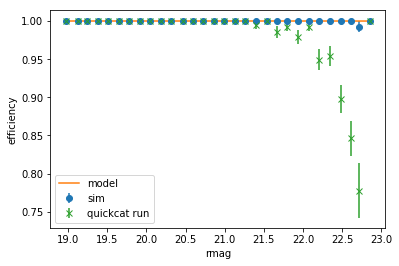

In [20]:
# simply use RFLUX for snr
######################
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["TRUEZ"]>2.)
z=table["Z"][qsos]
tz=table["TRUEZ"][qsos]
dz=z-tz
good=(table["ZWARN"][qsos]==0)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5

qgood=None
if qtable is not None : # quickcat output
    qgood=(qtable["ZWARN"][qsos]==0)


######################

bins=30
bin_rmag,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(bin_rmag,eff,err,fmt="o",label="sim")
qso_efficiency_params=[23.,0.3]
result=scipy.optimize.least_squares(sigmoid_residuals,qso_efficiency_params,args=(bin_rmag,eff,err)) 
qso_efficiency_params=result.x
plt.plot(bin_rmag,sigmoid(qso_efficiency_params,bin_rmag),"-",label="model")

if qgood is not None :
    bin_rmag,eff,err=efficiency(rmag,qgood,bins=bins)
    plt.errorbar(bin_rmag,eff,err,fmt="x",label="quickcat run")

plt.xlabel("rmag")
plt.ylabel("efficiency")
plt.legend(loc="lower left")

print("QSO redshift efficiency parameters = ",qso_efficiency_params)

quickcat_params["LYA_QSO"]=dict()
quickcat_params["LYA_QSO"]["EFFICIENCY"]=dict()
quickcat_params["LYA_QSO"]["EFFICIENCY"]["SIGMOID_CUTOFF"]=float(qso_efficiency_params[0])
quickcat_params["LYA_QSO"]["EFFICIENCY"]["SIGMOID_FUDGE"]=float(qso_efficiency_params[1])

(0.0, 1.4)

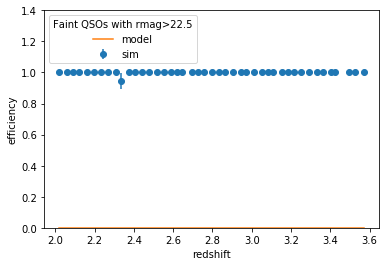

In [21]:
meff=sigmoid(params,rmag)
plt.figure()
mcut=22.5
s=(rmag>mcut) # select faint ones to increase contrast in z
bins=50
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="sim")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint QSOs with rmag>{}".format(mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])

## Lya QSO (z>2) redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of QSOs=4287
LYA_QSO redshift error parameters =  [0.00045565 0.17072328]


Text(0,0.5,'rms dz/(1+z)')

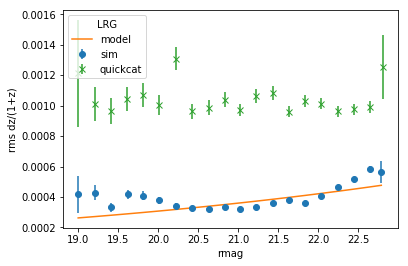

In [22]:
# QSO redshift uncertainties
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["TRUEZ"]>2.)
z=table["Z"][qsos]
dz=z-table["TRUEZ"][qsos]
good=(table["ZWARN"][qsos]==0)&(np.abs(dz/(1+z))<0.02)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5

qgood=None
qz=None
qdz=None
if qtable is not None : # quickcat output
    qz=qtable["Z"][qsos]
    qdz=qz-qtable["TRUEZ"][qsos]
    qgood=(qtable["ZWARN"][qsos]==0)&(np.abs(qdz/(1+qz))<0.02)



bins=20
binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

params=[1.,1.2]
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binflux,rms,rmserr))
params=result.x
print("LYA_QSO redshift error parameters = ",params)
quickcat_params["LYA_QSO"]["UNCERTAINTY"]=dict()
quickcat_params["LYA_QSO"]["UNCERTAINTY"]["SIGMA"]=float(params[0])
quickcat_params["LYA_QSO"]["UNCERTAINTY"]["POWER_LAW_INDEX"]=float(params[1])

model = redshift_error(params,binflux)

plt.errorbar(binmag,rms,rmserr,fmt="o",label="sim")
plt.plot(binmag,model,"-",label="model")

if qz is not None :
    qbinmag,qvar,qerr,nn=prof(rmag[qgood],((qdz/(1+qz))**2)[qgood],bins=bins)
    qvar_err = np.sqrt(2/nn)*qvar
    qrms=np.sqrt(qvar)
    qrmserr=0.5*qvar_err/qrms
    plt.errorbar(qbinmag,qrms,qrmserr,fmt="x",label="quickcat")

plt.legend(loc="upper left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")

In [23]:
# write results to a yaml file
with open(quickcat_param_filename, 'w') as outfile:
    yaml.dump(quickcat_params, outfile, default_flow_style=False)